In [10]:
pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pareto

import pm4py

In [12]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
import gzip
dom_decl_filename = '/content/gdrive/My Drive/_ComputerScience/BusinessInformationSystems/BPI_challenge_2020/DomesticDeclarations/DomesticDeclarations.xes.gz'
dom_decl_log = xes_importer.apply(dom_decl_filename)

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [15]:
print(dom_decl_log[0])
print(dom_decl_log[0][0])

{'attributes': {'id': 'declaration 86791', 'concept:name': 'declaration 86791', 'BudgetNumber': 'budget 86566', 'DeclarationNumber': 'declaration number 86792', 'Amount': 26.85120450862128}, 'events': [{'id': 'st_step 86794_0', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Declaration SUBMITTED by EMPLOYEE', 'time:timestamp': datetime.datetime(2017, 1, 9, 9, 49, 50, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'org:role': 'EMPLOYEE'}, '..', {'id': 'dd_declaration 86791_20', 'org:resource': 'SYSTEM', 'concept:name': 'Payment Handled', 'time:timestamp': datetime.datetime(2017, 1, 12, 17, 31, 22, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'org:role': 'UNDEFINED'}]}
{'id': 'st_step 86794_0', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Declaration SUBMITTED by EMPLOYEE', 'time:timestamp': datetime.datetime(2017, 1, 9, 9, 49, 50, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'org:role': 'EMPLOYEE'}


In [16]:
len(dom_decl_log)

10500

In [17]:
dom_decl_log = pm4py.filter_start_activities(dom_decl_log, {'Declaration SUBMITTED by EMPLOYEE'})
len(dom_decl_log)

10365

In [18]:
dom_decl_log = pm4py.filter_end_activities(dom_decl_log, 'Payment Handled')
len(dom_decl_log)

10042

In [19]:
dom_decl_log = pm4py.filter_event_attribute_values(dom_decl_log, 'concept:name', 'Declaration FOR_APPROVAL by ADMINISTRATION', level="case", retain=False)
len(dom_decl_log)

10041

In [20]:
#dom_decl_log = pm4py.filter_end_activities(dom_decl_log, 'Declaration REJECTED by EMPLOYEE')
#len(dom_decl_log)

In [21]:
dom_dec_log = log_converter.apply(dom_decl_log, variant=log_converter.Variants.TO_DATA_FRAME)

profile = dom_dec_log.groupby('case:concept:name').agg(
Activity = ('concept:name', 'count'),\
Activity_list = ('concept:name', lambda x: ','.join(x) ),\
Resource = ('org:resource', 'nunique'),\
Duration = ('time:timestamp', lambda x: x.max()- x.min()),\
)

In [22]:
# filtering and basic analysis
wrong_duration = profile[(profile['Duration'] < '0:10:0')]
print('wrong duration', wrong_duration)

short_activity_list = profile[(profile['Activity']) == 1]
print('short act list:', short_activity_list)

wrong duration Empty DataFrame
Columns: [Activity, Activity_list, Resource, Duration]
Index: []
short act list: Empty DataFrame
Columns: [Activity, Activity_list, Resource, Duration]
Index: []


In [23]:
def filter_declaration(decl_df):
  decl_df = decl_df[decl_df['Activity'] > 2]
  decl_df = decl_df[decl_df['Duration'] > np.timedelta64(25, 'h')]
  return decl_df

In [24]:
dom_decl_df = filter_declaration(profile)
print(dom_decl_df)

                    Activity  \
case:concept:name              
declaration 100000         5   
declaration 100005         5   
declaration 100010         5   
declaration 100015         6   
declaration 100021         6   
...                      ...   
declaration 99973          5   
declaration 99978          5   
declaration 99983          6   
declaration 99989          6   
declaration 99995          5   

                                                        Activity_list  \
case:concept:name                                                       
declaration 100000  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100005  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100010  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100015  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
declaration 100021  Declaration SUBMITTED by EMPLOYEE,Declaration ...   
...                                                               ...   

In [25]:
# question 1
mean_duration = dom_decl_df[(dom_decl_df['Duration'] > np.timedelta64(25, 'h'))].agg('mean')
print('mean dur = ', mean_duration)

mean dur =  Activity                      5.488398
Resource                           2.0
Duration    11 days 14:46:14.277362812
dtype: object


/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:577: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return f(*args, **kwargs)


In [26]:
from pm4py.algo.filtering.log.variants import variants_filter
variant_dom_decl = variants_filter.get_variants(dom_decl_log)

In [27]:
from pm4py.statistics.traces.generic.log import case_statistics
variants_count = case_statistics.get_variant_statistics(dom_decl_log)

In [28]:
len(variants_count)

62

In [29]:
variants_count

[{'count': 4618,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 2473,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 1392,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 575,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by PRE_APPROVER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 345,
  'variant': 'Declaration SUBMITTED by EMPLOYEE,Declaration REJECTED by ADMINISTRATION,Declaration REJECTED by EMPLOYEE,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},


In [30]:
def analyse_variant(variants_count):
  count_sum = 0
  for variant in variants_count:
    count_sum += variant['count']
  print("sum = ", count_sum)

  handled_count = 0
  never_approved = 0
  rejected = 0
  resubmitted = 0
  double_payments = 0
  approved_by_supervisor_count = 0
  for variant in variants_count:
    #print(variant['variant'])
    if "Handled" in variant['variant']:
      handled_count += variant['count']
    if "APPROVED" not in variant['variant']:
      never_approved += variant['count']
    if "REJECTED" in variant['variant']:
      rejected += variant['count']
    # resubmit
    if variant['variant'].count('SUBMITTED') > 1:
      resubmitted += variant['count'] * (variant['variant'].count('SUBMITTED') - 1)
    if variant['variant'].count('Payment Handled') > 1:
      double_payments += variant['count']
    if 'Declaration FINAL_APPROVED by SUPERVISOR' in variant['variant']:
      approved_by_supervisor_count += variant['count']

  print('handled_count', handled_count)
  handled_ratio = handled_count / count_sum
  print("handled ratio = ", handled_ratio)
  print("never approved = ", never_approved)
  print("never approved ratio = ", never_approved / count_sum)
  print("REJECTED = ", rejected)
  print("resubmitted", resubmitted)
  print("double payment", double_payments)
  print("final approved by supervisor", approved_by_supervisor_count)

In [31]:
analyse_variant(variants_count)

sum =  10041
handled_count 10041
handled ratio =  1.0
never approved =  0
never approved ratio =  0.0
REJECTED =  977
resubmitted 1115
double payment 0
final approved by supervisor 10041


In [173]:
variant_distr = []
for variant in variants_count:
  variant_distr.append(variant['count'])

In [182]:
for variant in variant_distr:
  if variant < 10:
    variant_distr.remove(variant)

[4618, 2473, 1392, 575, 345, 188, 77, 57, 49, 40, 36, 29, 22, 20, 14, 10]


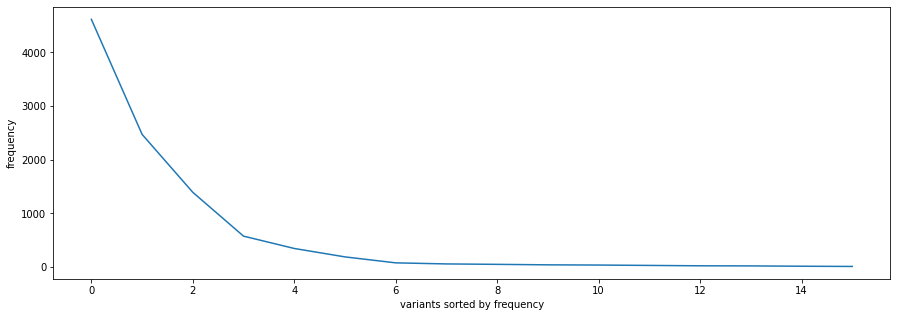

In [183]:
fig = plt.figure(figsize = (15, 5))
print(variant_distr)

#plt.hist(profile['Duration'].values, color = 'orange')
plt.plot(variant_distr)
plt.xlabel('variants sorted by frequency')
plt.ylabel('frequency')
plt.show()

In [186]:
import statistics

mean = statistics.mean(variant_distr)
median = statistics.median(variant_distr)
#mode = statistics.mode(variant_distr)

print('mean =', mean)
print('median =', median)
print('mode = ', mode)

mean = 621.5625
median = 53.0
mode =  16


In [36]:
####################
# Process discovery
####################

In [37]:
####################
# ALPHA MINER
####################

In [38]:
from pm4py.objects.petri_net.importer import importer as pnml_importer

## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(dom_decl_log)

/usr/local/lib/python3.7/dist-packages/pm4py/visualization/petrinet/__init__.py:20: UserWarning: please use the pm4py.visualization.petri_net package instead
  warnings.warn("please use the pm4py.visualization.petri_net package instead")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  after removing the cwd from sys.path.


replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

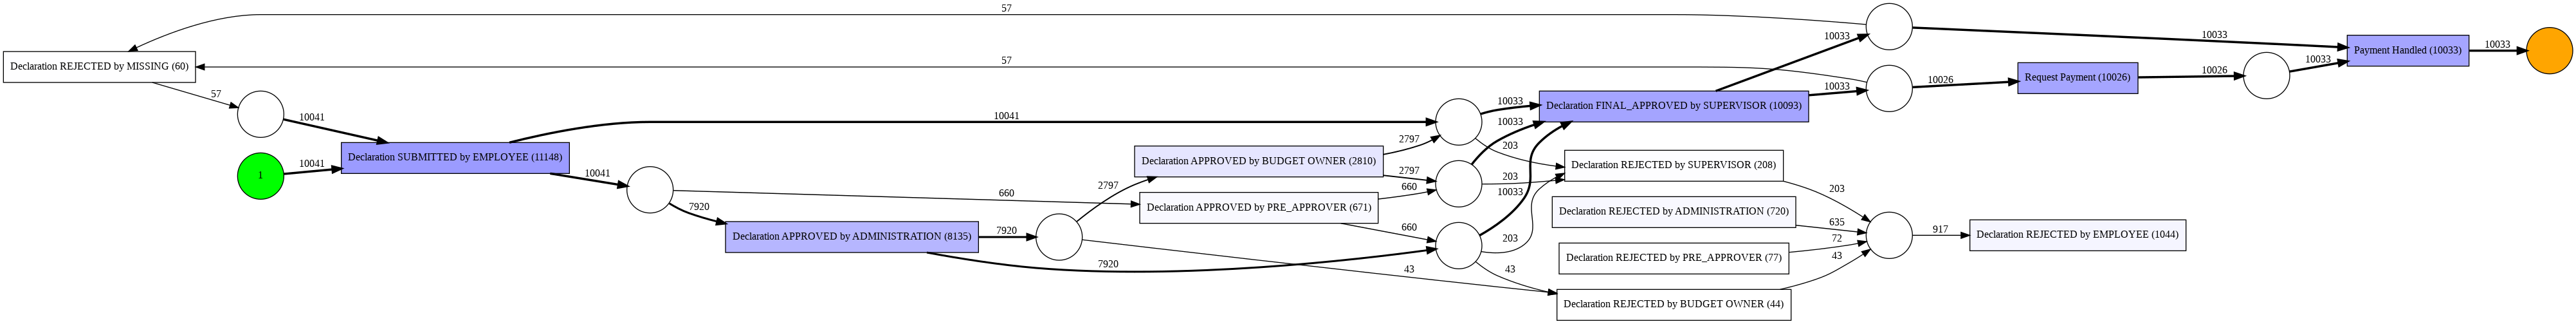

In [39]:
## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, parameters={alpha_miner.Variants.ALPHA_VERSION_CLASSIC.value.Parameters.START_TIMESTAMP_KEY:'0:0:0'}, log=dom_decl_log)
pn_visualizer.view(gviz)

In [40]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness_alpha = replay_fitness_evaluator.apply(dom_decl_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness_alpha)

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8459708794572264, 'log_fitness': 0.8449731173460986, 'percentage_of_fitting_traces': 0.0}


In [41]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec_alpha = precision_evaluator.apply(dom_decl_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec_alpha)

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

0.0


In [42]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen_alpha = generalization_evaluator.apply(dom_dec_log, net, initial_marking, final_marking)
print(gen_alpha)

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

0.9508401014184381


In [43]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp_alpha = simplicity_evaluator.apply(net)
print(simp_alpha)

0.5319148936170213


In [44]:
# ============================
# INDUCTIVE MINER
# ============================

In [45]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
# Discover process tree using inductive miner
tree = inductive_miner.apply_tree(dom_dec_log)

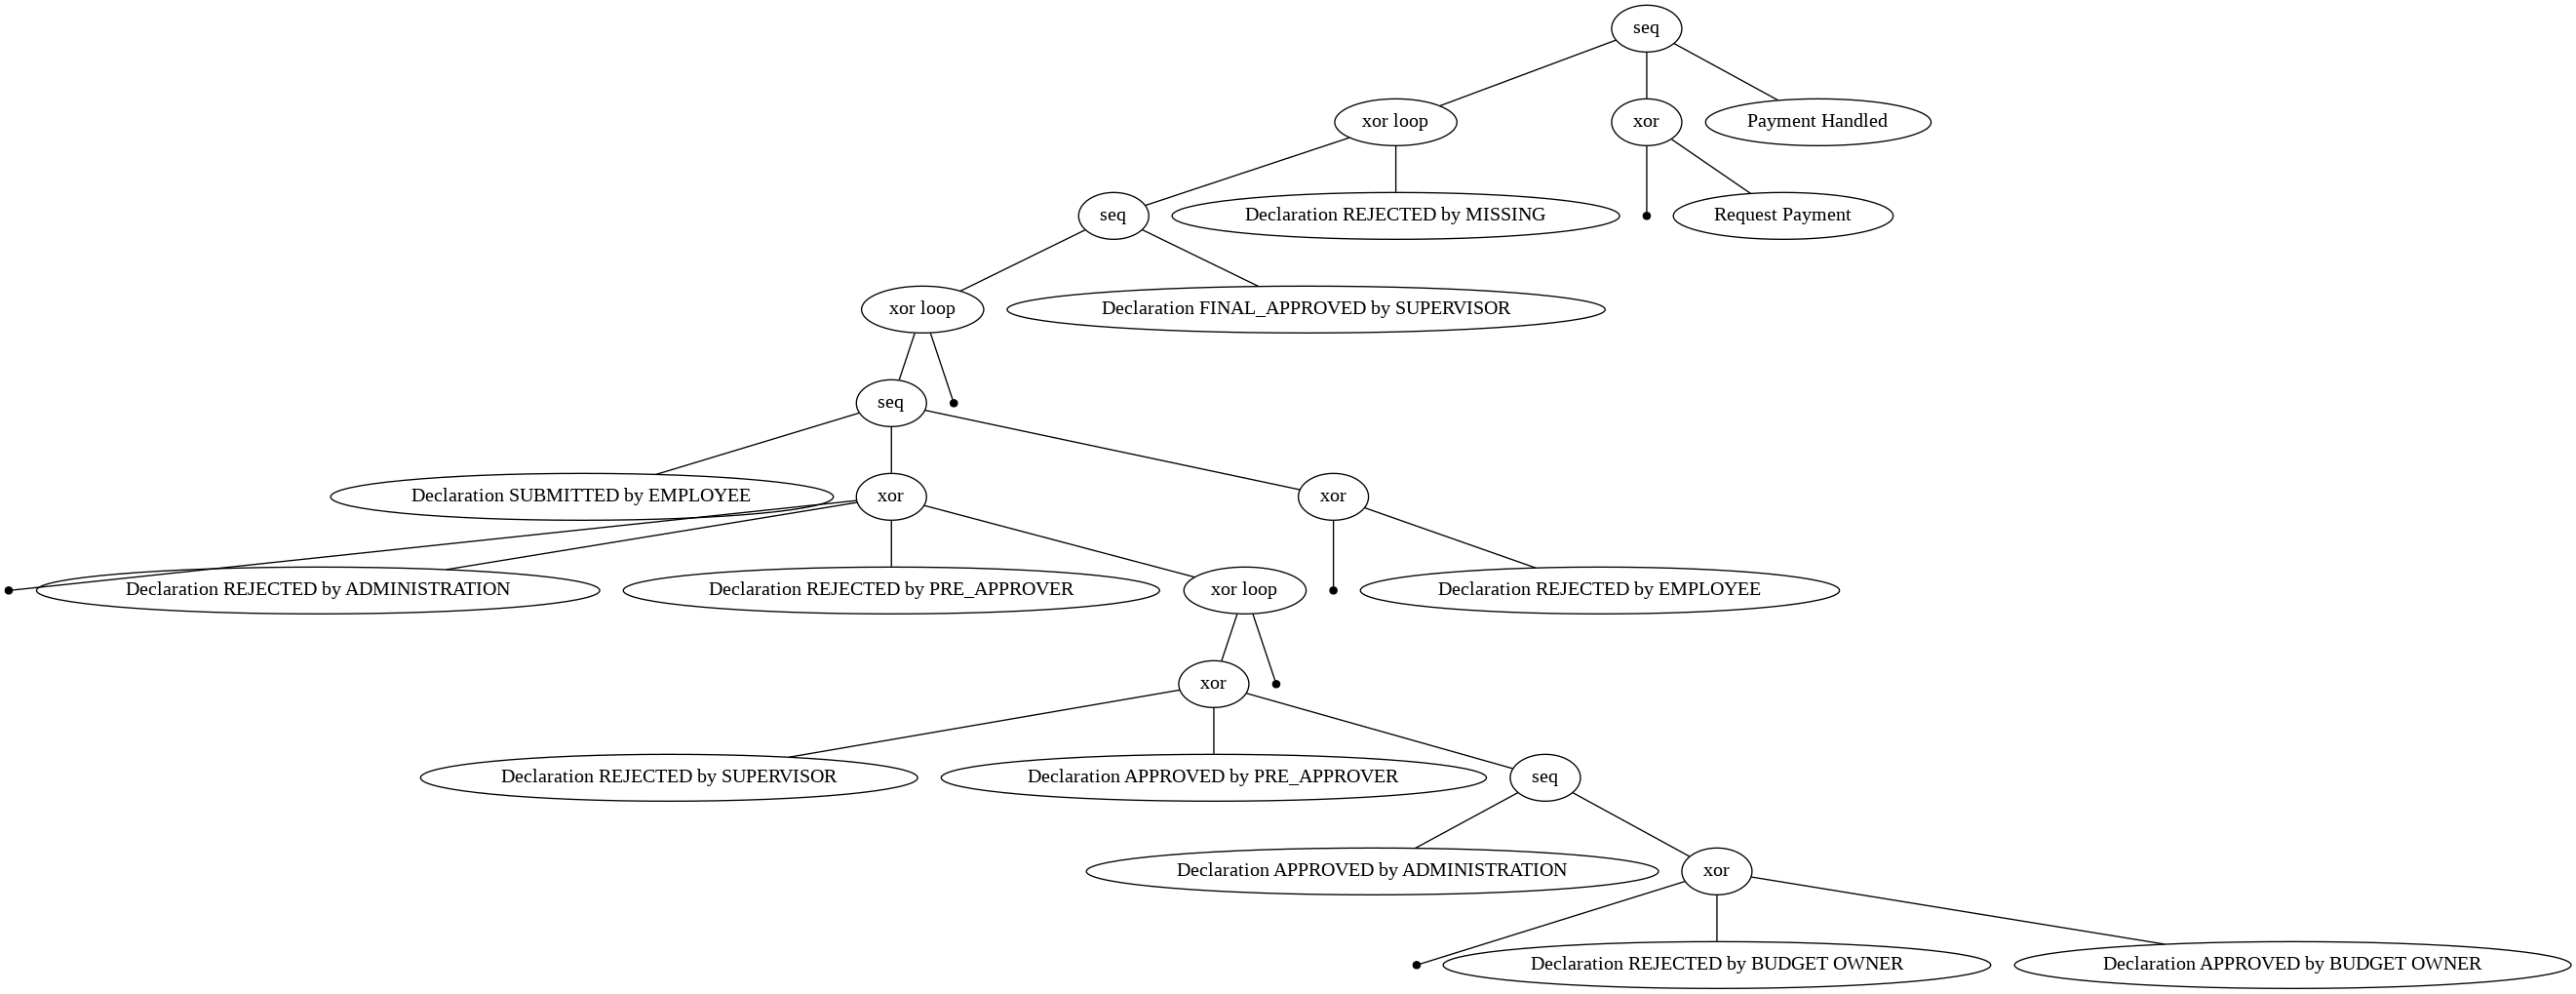

In [46]:
from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  


replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

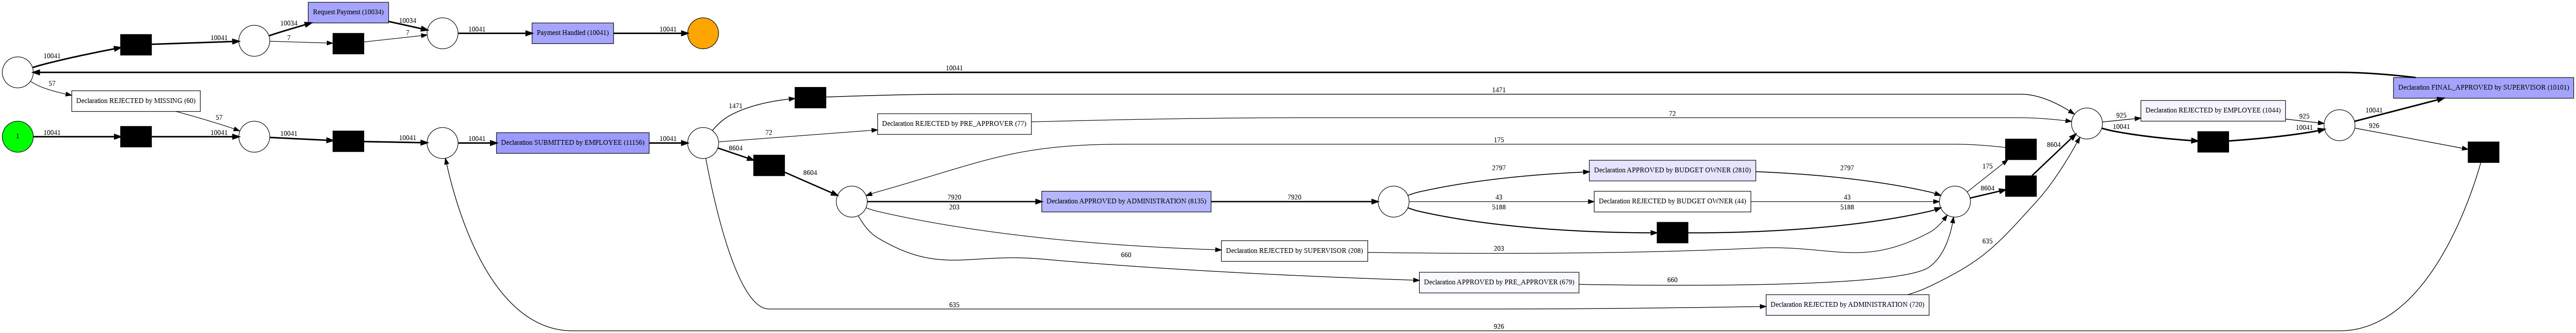

In [47]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(tree)
## Then visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=dom_dec_log)
pn_visualizer.view(gviz)

In [48]:
fitness_inductive = replay_fitness_evaluator.apply(dom_dec_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness_inductive)

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


In [49]:
prec_inductive = precision_evaluator.apply(dom_dec_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec_inductive)

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

0.6226180559452028


In [50]:
gen_inductive = generalization_evaluator.apply(dom_dec_log, net, initial_marking, final_marking)
print(gen_inductive)

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

0.9490358424877173


In [51]:
simp_inductive = simplicity_evaluator.apply(net)
print(simp_inductive)

0.6271186440677966


In [52]:
####################
# HEURISTIC MINER
####################

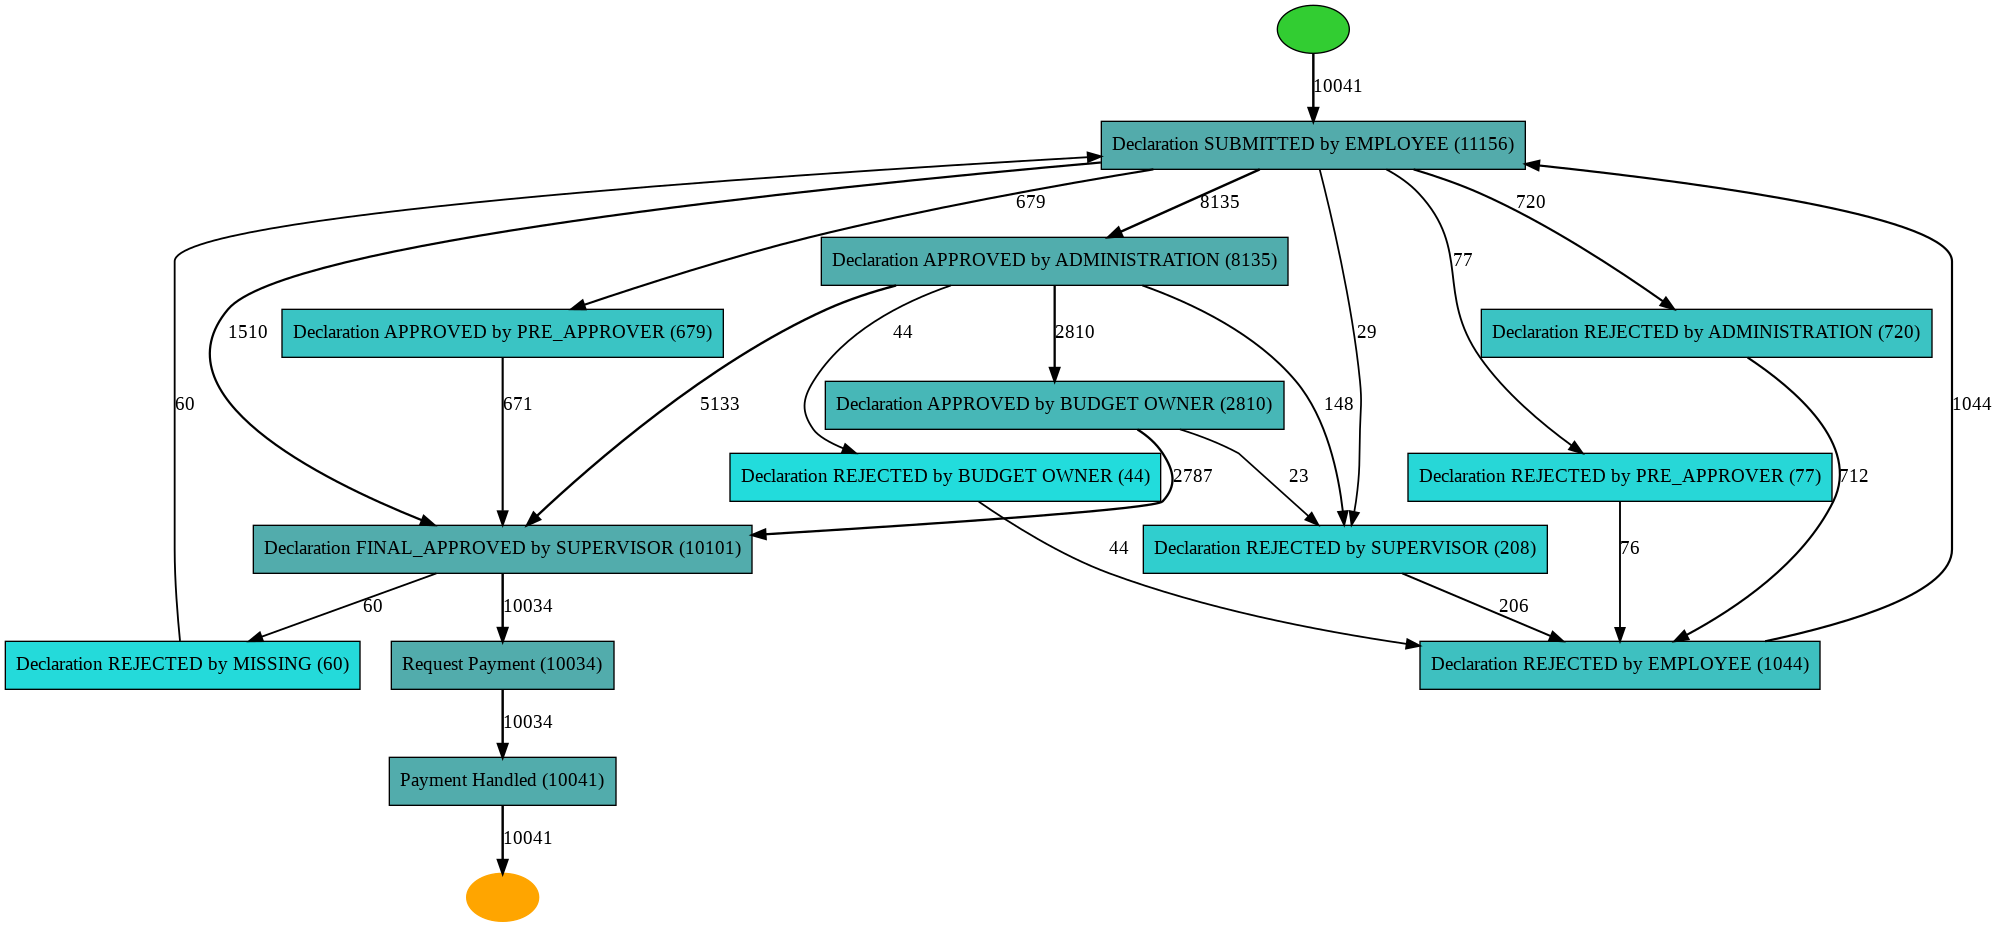

In [53]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
net = heuristics_miner.apply_heu(dom_dec_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.9})
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
gviz = hn_visualizer.apply(net)
hn_visualizer.view(gviz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  This is separate from the ipykernel package so we can avoid doing imports until


replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

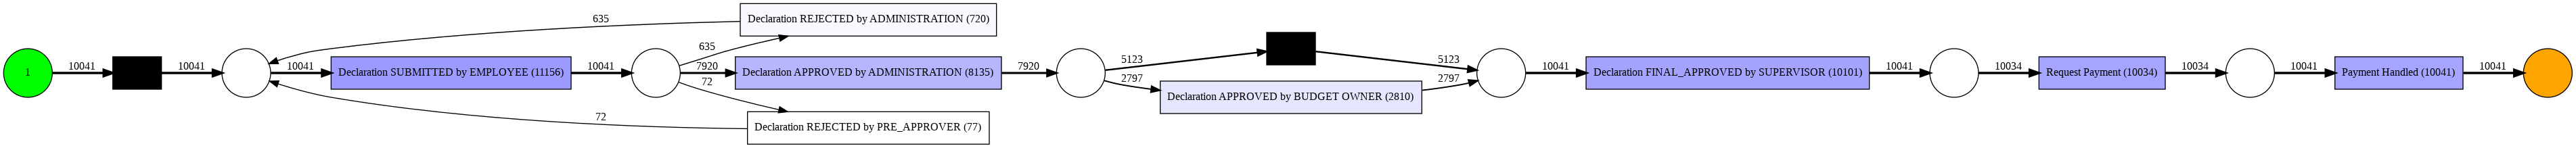

In [54]:
net, initial_marking, final_marking = heuristics_miner.apply(dom_dec_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.9995})

gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=dom_dec_log)
pn_visualizer.view(gviz)

In [55]:
fitness_heu = replay_fitness_evaluator.apply(dom_dec_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness_heu)

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

{'perc_fit_traces': 76.68558908475252, 'average_trace_fitness': 0.9612695526872327, 'log_fitness': 0.9679863053948058, 'percentage_of_fitting_traces': 76.68558908475252}


In [56]:
prec_heu = precision_evaluator.apply(dom_dec_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec_heu)

replaying log with TBR, completed variants ::   0%|          | 0/300 [00:00<?, ?it/s]

0.9530052216420398


In [57]:
gen_heu = generalization_evaluator.apply(dom_dec_log, net, initial_marking, final_marking)
print(gen_heu)

replaying log with TBR, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

0.9755488765864572


In [58]:
simp_heu = simplicity_evaluator.apply(net)
print(simp_heu)

0.8181818181818181


In [59]:
####################
# DFG
####################

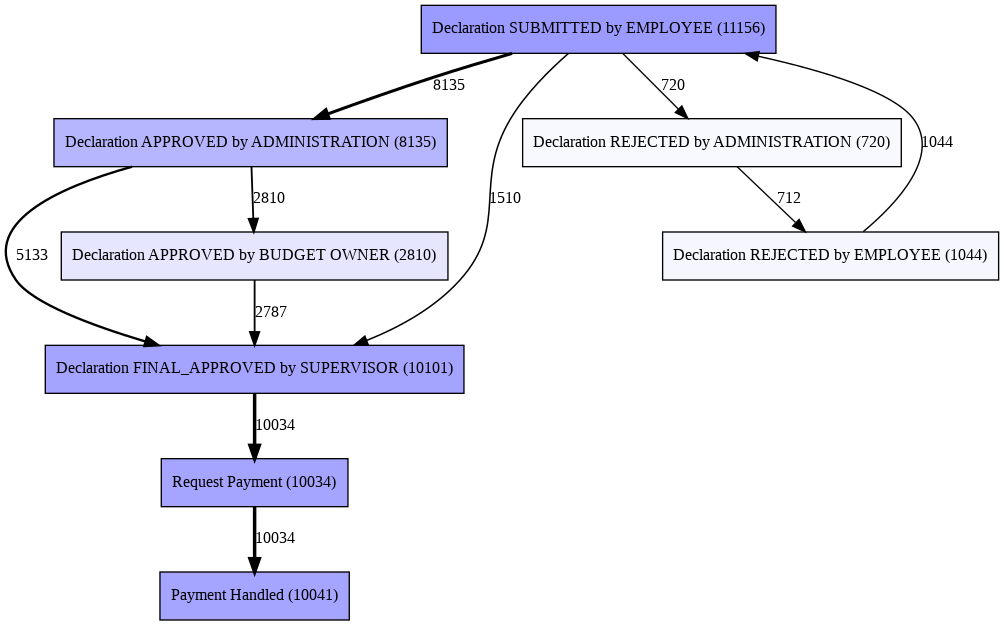

In [60]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(dom_decl_log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=dom_decl_log, variant=dfg_visualization.Variants.FREQUENCY, parameters={dfg_visualization.Variants.FREQUENCY.value.Parameters.MAX_NO_EDGES_IN_DIAGRAM:10})
dfg_visualization.view(gviz)

In [61]:
# with int decl we can't filter data on start activity, because start-end dates of trip can be submitted in advance before submitting declaration
# there is no need to pay apriori

In [233]:
int_decl_filename = '/content/gdrive/My Drive/_ComputerScience/BusinessInformationSystems/BPI_challenge_2020/InternationalDeclarations/InternationalDeclarations.xes.gz'
int_decl_log = xes_importer.apply(int_decl_filename)

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

In [234]:
print(len(int_decl_log))

6449


In [235]:
print(int_decl_log[0])

{'attributes': {'Permit travel permit number': 'travel permit number 76456', 'DeclarationNumber': 'declaration number 76458', 'Amount': 39.66456144659199, 'RequestedAmount': 39.66456144659199, 'Permit TaskNumber': 'UNKNOWN', 'Permit BudgetNumber': 'budget 922', 'OriginalAmount': 39.66456144659199, 'Permit ProjectNumber': 'UNKNOWN', 'concept:name': 'declaration 76457', 'Permit OrganizationalEntity': 'organizational unit 65458', 'travel permit number': 'travel permit number 76456', 'Permit RequestedBudget': 41.613444658859, 'id': 'declaration 76457', 'Permit ID': 'travel permit 76455', 'Permit id': 'travel permit 76455', 'BudgetNumber': 'budget 144133', 'Permit ActivityNumber': 'activity 46005', 'AdjustedAmount': 39.66456144659199}, 'events': [{'id': 'rv_travel permit 76455_6', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Start trip', 'time:timestamp': datetime.datetime(2016, 10, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'org:role': 'EMPLOYEE'}, '..', {'id

In [236]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Payment Handled')
len(int_decl_log)

6187

In [237]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Start trip')
len(int_decl_log)

6187

In [238]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'End trip')
len(int_decl_log)

6187

In [239]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Declaration FINAL_APPROVED by SUPERVISOR')
len(int_decl_log)

5944

In [240]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Declaration REJECTED by MISSING', retain = False)
len(int_decl_log)

5870

In [241]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Permit APPROVED by ADMINISTRATION')
len(int_decl_log)

4413

In [249]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Declaration REJECTED by DIRECTOR', retain = False)
len(int_decl_log)

4412

In [250]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Permit REJECTED by MISSING', retain = False)
len(int_decl_log)

4411

In [256]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Permit REJECTED by DIRECTOR', retain = False)
len(int_decl_log)

4410

In [278]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Permit REJECTED by BUDGET OWNER', retain = False)
len(int_decl_log)

4382

In [287]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Declaration REJECTED by SUPERVISOR', retain = False)
len(int_decl_log)

4311

In [293]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Declaration REJECTED by BUDGET OWNER', retain = False)
len(int_decl_log)

4279

In [296]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Permit REJECTED by SUPERVISOR', retain = False)
len(int_decl_log)

4214

In [297]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Permit REJECTED by ADMINISTRATION', retain = False)
len(int_decl_log)

4147

In [300]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Declaration REJECTED by ADMINISTRATION', retain = False)
len(int_decl_log)

3211

In [301]:
int_decl_log = pm4py.filter_event_attribute_values(int_decl_log, 'concept:name', 'Declaration REJECTED by EMPLOYEE', retain = False)
len(int_decl_log)

3211

In [94]:
int_decl_log = log_converter.apply(int_decl_log, variant=log_converter.Variants.TO_DATA_FRAME)

profile = int_decl_log.groupby('case:concept:name').agg(
Activity = ('concept:name', 'count'),\
Activity_list = ('concept:name', lambda x: ','.join(x) ),\
Resource = ('org:resource', 'nunique'),\
Duration = ('time:timestamp', lambda x: x.max()- x.min()),\
)

In [95]:
print(len(int_decl_log))

70041


In [96]:
int_decl_df = filter_declaration(profile)
print(int_decl_df)

                   Activity  \
case:concept:name             
declaration 1002         10   
declaration 10024        12   
declaration 10026        12   
declaration 10046        10   
declaration 10069        10   
...                     ...   
declaration 9934         10   
declaration 9945         10   
declaration 9955         12   
declaration 9968         18   
declaration 9995         18   

                                                       Activity_list  \
case:concept:name                                                      
declaration 1002   Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10024  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10026  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10046  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
declaration 10069  Permit SUBMITTED by EMPLOYEE,Permit APPROVED b...   
...                                                              ...   
declaration 9934   P

In [302]:
variant_int_decl = variants_filter.get_variants(int_decl_log)
variants_count_int = case_statistics.get_variant_statistics(int_decl_log)

In [98]:
mean_duration = int_decl_df[(int_decl_df['Duration'] > np.timedelta64(25, 'h'))].agg('mean')
print('mean dur = ', mean_duration)

mean dur =  Activity                     11.320672
Resource                           2.0
Duration    86 days 15:13:31.138354614
dtype: object


/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:577: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return f(*args, **kwargs)


In [303]:
variants_count_int

[{'count': 1369,
  'variant': 'Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,Permit FINAL_APPROVED by SUPERVISOR,Start trip,End trip,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 624,
  'variant': 'Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,Permit APPROVED by BUDGET OWNER,Permit FINAL_APPROVED by SUPERVISOR,Start trip,End trip,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 157,
  'variant': 'Start trip,End trip,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,Permit FINAL_APPROVED by SUPERVISOR,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled'},
 {'count': 94,
  'variant': 'Permit 

In [304]:
len(variants_count_int)

117

In [260]:
analyse_variant(variants_count_int)

sum =  4410
handled_count 4410
handled ratio =  1.0
never approved =  0
never approved ratio =  0.0
REJECTED =  1199
resubmitted 5946
double payment 0
final approved by supervisor 4410


In [261]:
variant_distr = []
for variant in variants_count_int:
  variant_distr.append(variant['count'])

In [262]:
mean = statistics.mean(variant_distr)
median = statistics.median(variant_distr)
mode = statistics.mode(variant_distr)

print('mean =', mean)
print('median =', median)
print('mode = ', mode)

mean = 11.85483870967742
median = 1.0
mode =  1


In [263]:
len(variant_distr)

372

In [272]:
for variant in variant_distr:
  if variant < 10:
    variant_distr.remove(variant)

In [273]:
len(variant_distr)

47

[1369, 624, 311, 188, 157, 94, 85, 73, 62, 62, 50, 46, 42, 40, 40, 38, 33, 28, 27, 27, 25, 24, 23, 21, 21, 20, 18, 18, 18, 17, 16, 16, 16, 15, 15, 15, 13, 12, 12, 11, 11, 11, 10, 10, 10, 10, 1]


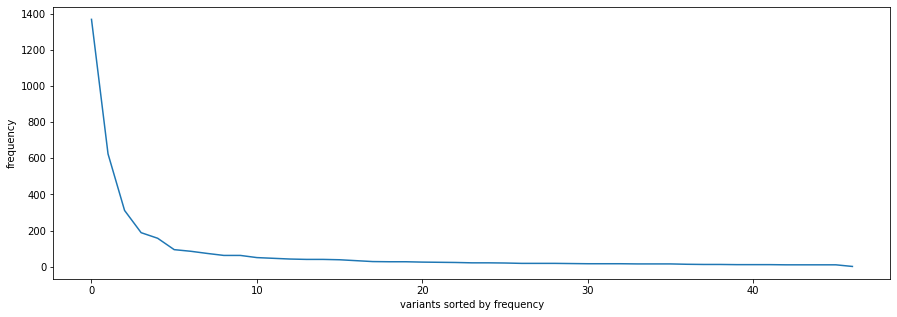

In [274]:
fig = plt.figure(figsize = (15, 5))
print(variant_distr)

plt.plot(variant_distr)
plt.xlabel('variants sorted by frequency')
plt.ylabel('frequency')
plt.show()

In [275]:
import statistics

mean = statistics.mean(variant_distr)
median = statistics.median(variant_distr)
mode = statistics.mode(variant_distr)

print('mean =', mean)
print('median =', median)
print('mode = ', mode)

mean = 80.95744680851064
median = 21
mode =  10


In [ ]:
####################
# ALPHA MINER
####################

In [305]:
from pm4py.objects.petri_net.importer import importer as pnml_importer
 
## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(int_decl_log)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  after removing the cwd from sys.path.


replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

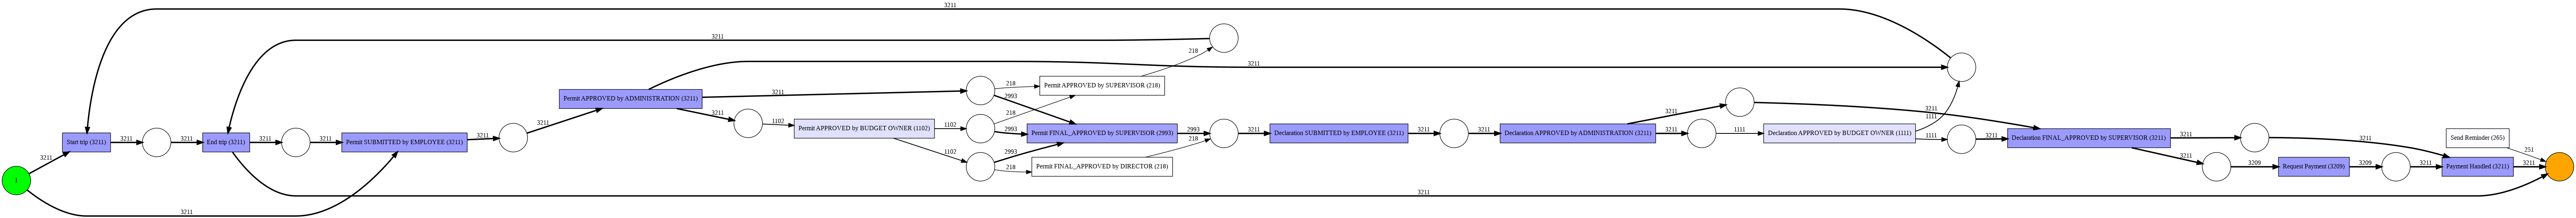

In [306]:
## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=int_decl_log)
pn_visualizer.view(gviz)

In [308]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness_alpha = replay_fitness_evaluator.apply(int_decl_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness_alpha)

replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.75538481864979, 'log_fitness': 0.7599553224808151, 'percentage_of_fitting_traces': 0.0}


In [309]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec_alpha = precision_evaluator.apply(int_decl_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec_alpha)

replaying log with TBR, completed variants ::   0%|          | 0/605 [00:00<?, ?it/s]

0.0


In [311]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen_alpha = generalization_evaluator.apply(int_decl_log, net, initial_marking, final_marking)
print(gen_alpha)

replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

0.9710585068150488


In [312]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp_alpha = simplicity_evaluator.apply(net)
print(simp_alpha)

0.6296296296296295


In [ ]:
# ============================
# INDUCTIVE MINER
# ============================

In [314]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
# Discover process tree using inductive miner
tree = inductive_miner.apply_tree(int_decl_log)


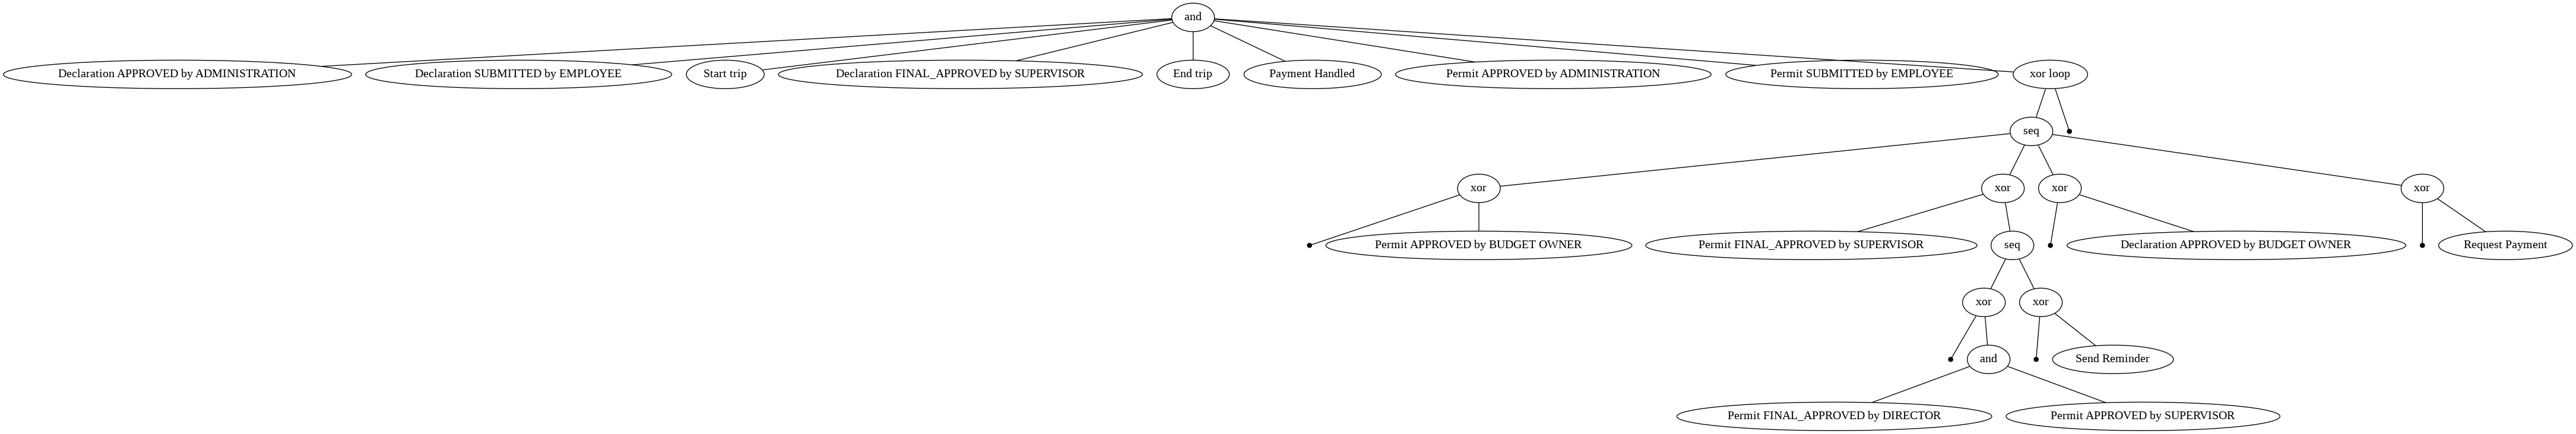

In [315]:
from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  


replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

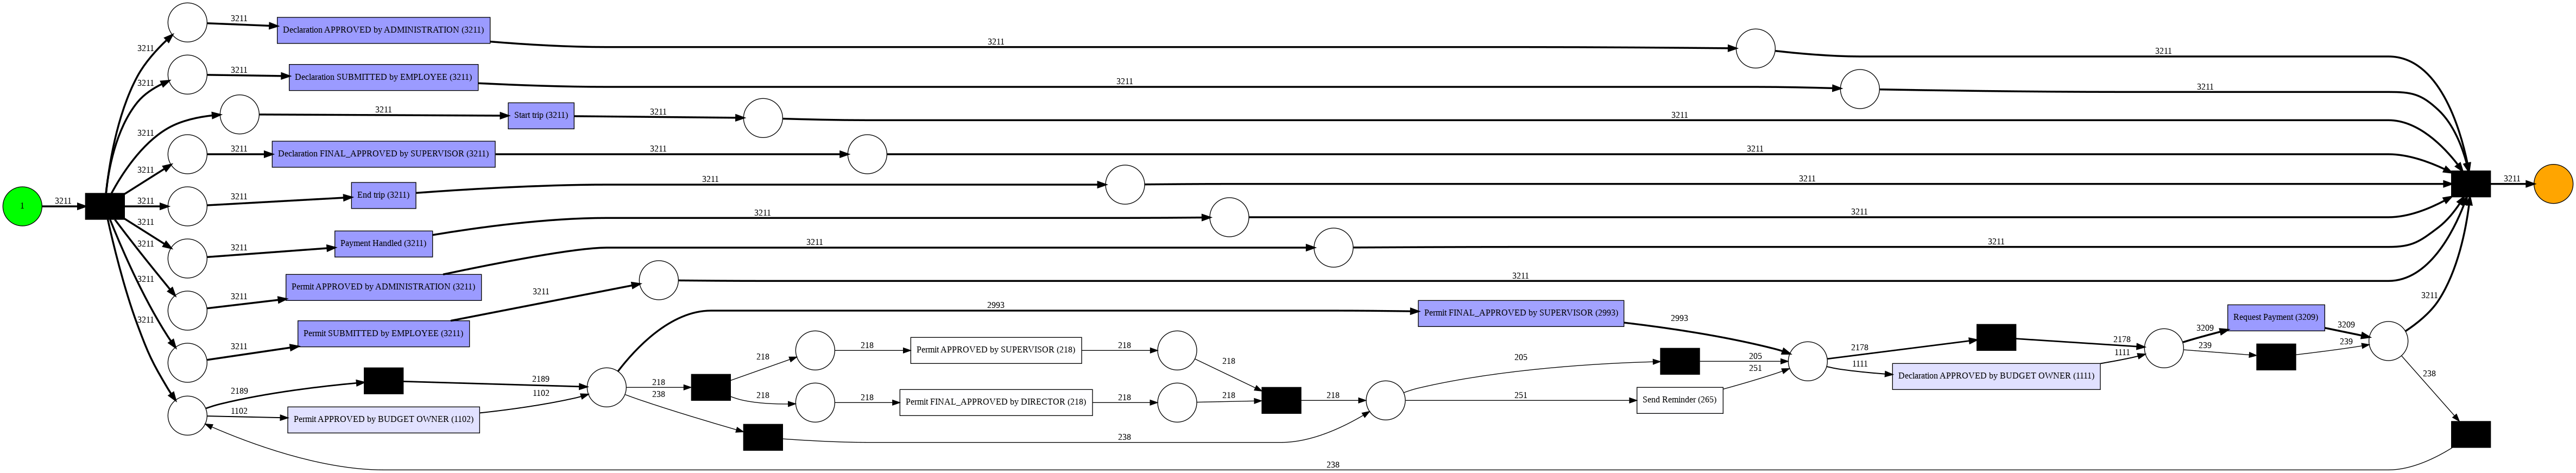

In [316]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(tree)
## Then visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                          variant=pn_visualizer.Variants.FREQUENCY,
                          log=int_decl_log)
pn_visualizer.view(gviz)


In [317]:
fitness_inductive = replay_fitness_evaluator.apply(int_decl_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness_inductive)

prec_inductive = precision_evaluator.apply(int_decl_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec_inductive)

gen_inductive = generalization_evaluator.apply(int_decl_log, net, initial_marking, final_marking)
print(gen_inductive)

simp_inductive = simplicity_evaluator.apply(net)
print(simp_inductive)

replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/605 [00:00<?, ?it/s]

0.1728968131980736


replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

0.9638139618778068
0.6385542168674699


In [ ]:
####################
# HEURISTIC MINER
####################

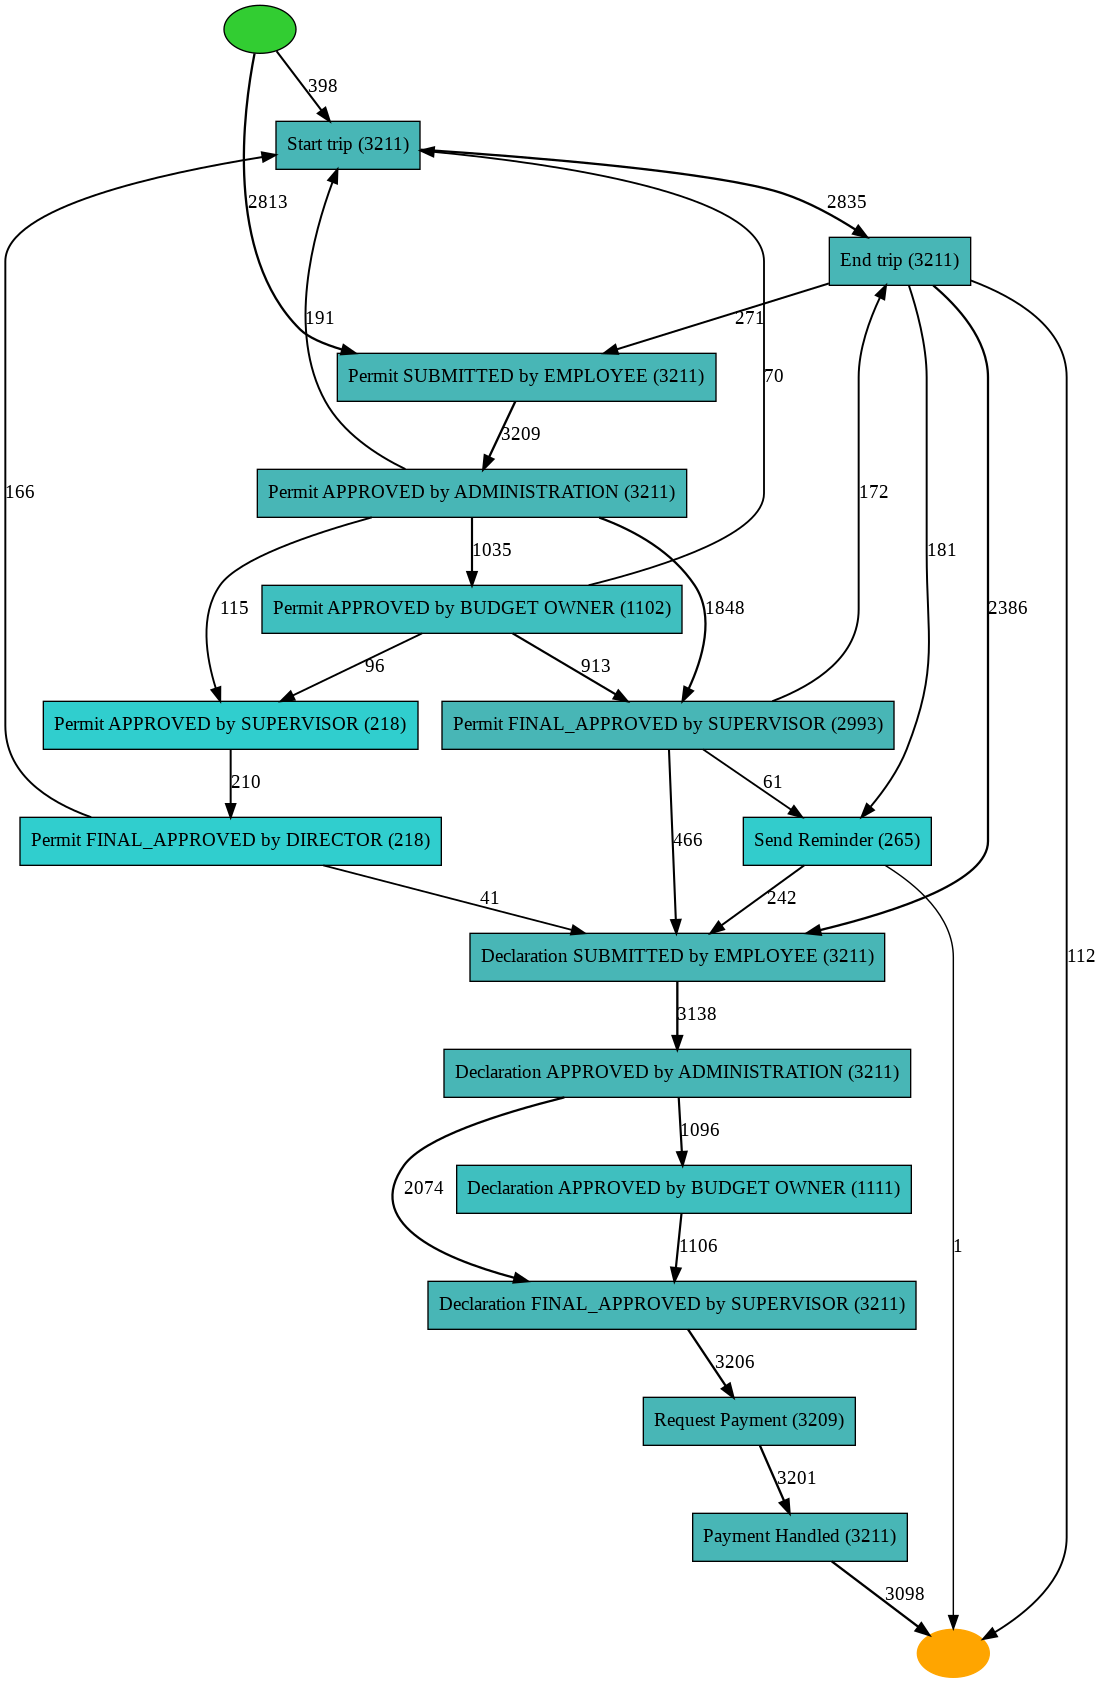

In [324]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
net = heuristics_miner.apply_heu(int_decl_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.95})
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
gviz = hn_visualizer.apply(net)
hn_visualizer.view(gviz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  


replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

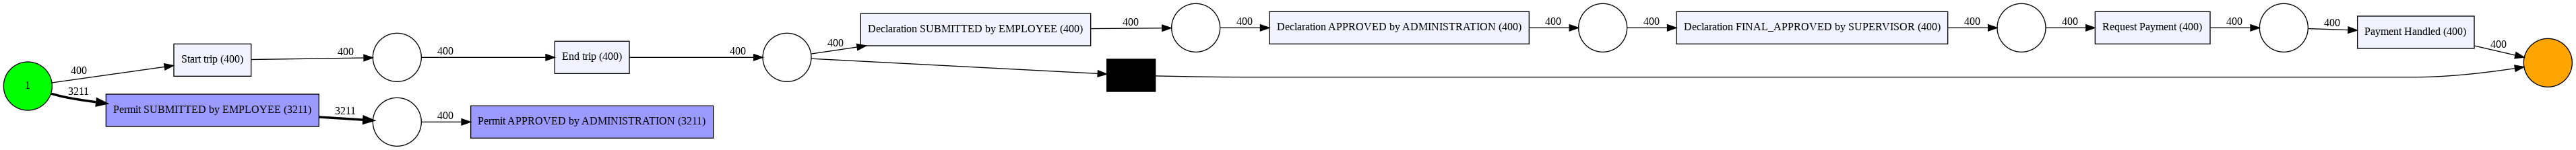

In [326]:
net, initial_marking, final_marking = heuristics_miner.apply(int_decl_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.9995})
gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=int_decl_log)
pn_visualizer.view(gviz)

In [327]:
fitness_heu = replay_fitness_evaluator.apply(int_decl_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness_heu)
prec_heu = precision_evaluator.apply(int_decl_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec_heu)
gen_heu = generalization_evaluator.apply(int_decl_log, net, initial_marking, final_marking)
print(gen_heu)
simp_heu = simplicity_evaluator.apply(net)
print(simp_heu)

replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.942329319353575, 'log_fitness': 0.9423369459216784, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/605 [00:00<?, ?it/s]

0.9726373182552503


replaying log with TBR, completed variants ::   0%|          | 0/117 [00:00<?, ?it/s]

0.8841168224227173
1.0


In [ ]:
####################
# DFG
####################

In [328]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(int_decl_log)

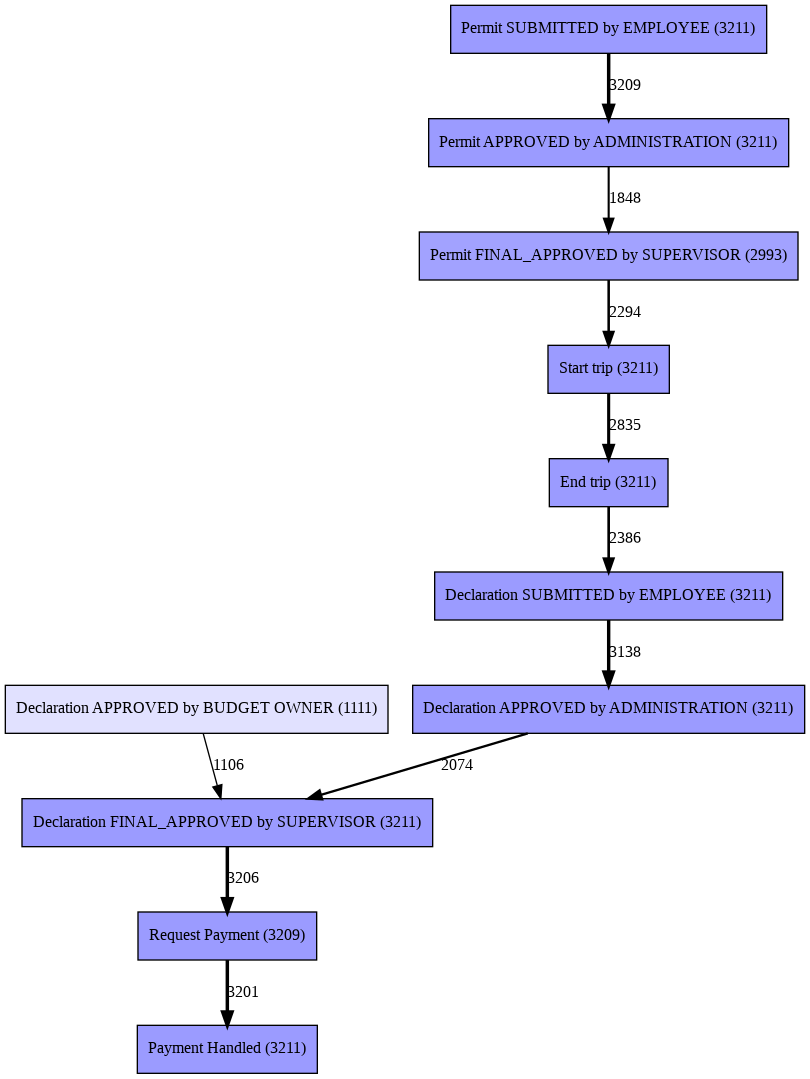

In [329]:
# Visualise
gviz = dfg_visualization.apply(dfg, log=int_decl_log, variant=dfg_visualization.Variants.FREQUENCY, parameters={dfg_visualization.Variants.FREQUENCY.value.Parameters.MAX_NO_EDGES_IN_DIAGRAM:10})
dfg_visualization.view(gviz)

[ 3389741000000000  5366384000000000  5366384000000000  7439903000000000
   694989000000000 12713884000000000  8404183000000000 16849974000000000
  4124622000000000 10172532000000000]


TypeError: ignored

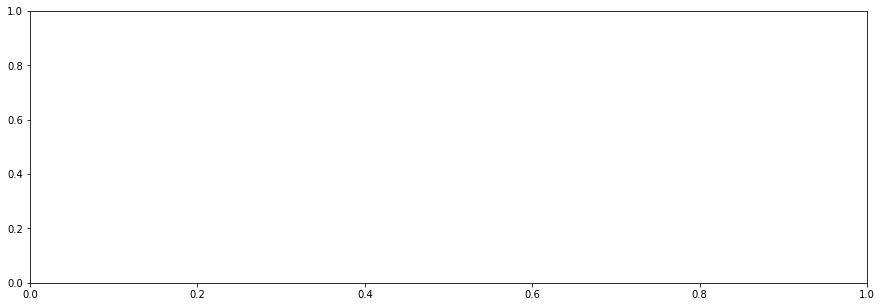

In [73]:
fig = plt.figure(figsize = (15, 5))
print(profile['Duration'].values[0:10])

plt.hist(profile['Duration'].values, color = 'orange')
#plt.xlabel('variants sorted by frequency')
#plt.ylabel('frequency')
plt.show()

In [ ]:
len(dom_decl_log)

In [ ]:
from pm4py.objects.petri_net.importer import importer as pnml_importer

In [ ]:
## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(dom_decl_log)

In [ ]:
## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=dom_decl_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness_alpha = replay_fitness_evaluator.apply(dom_decl_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print('fitness alpha miner:', round(fitness_alpha['average_trace_fitness'], 2))

In [ ]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec_alpha = precision_evaluator.apply(dom_decl_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('precision alpha miner:', round(prec_alpha, 2))